### Setup
1. In VS Code, open up project folder directory
2. Enter `pip install uv`
3. Enter `uv init`
4. Make sure to activate new python venv (e.g. Python Interpreter or `.venv/Scripts/activate`)
5. Create `requirements.txt`, add in the libraries to install (e.g. langchain, langsmith)
6. Enter `uv add -r requirements.txt` to install libraries

### Build a basic chatbot using LangGraph (Graph API)
-  Basic Components of LangGraph:
    1. Edges
    2. Nodes
    3. State
- There are 2 ways to do this:
    1. Graph API
    2. Functional API
- Given the use case is to convert YouTube video into Blogs using LLM:
    1. Start off by converting YouTube video into transcripts
    2. Create a blog title using the transcripts
    3. Generate blog content based on blog title and transcripts

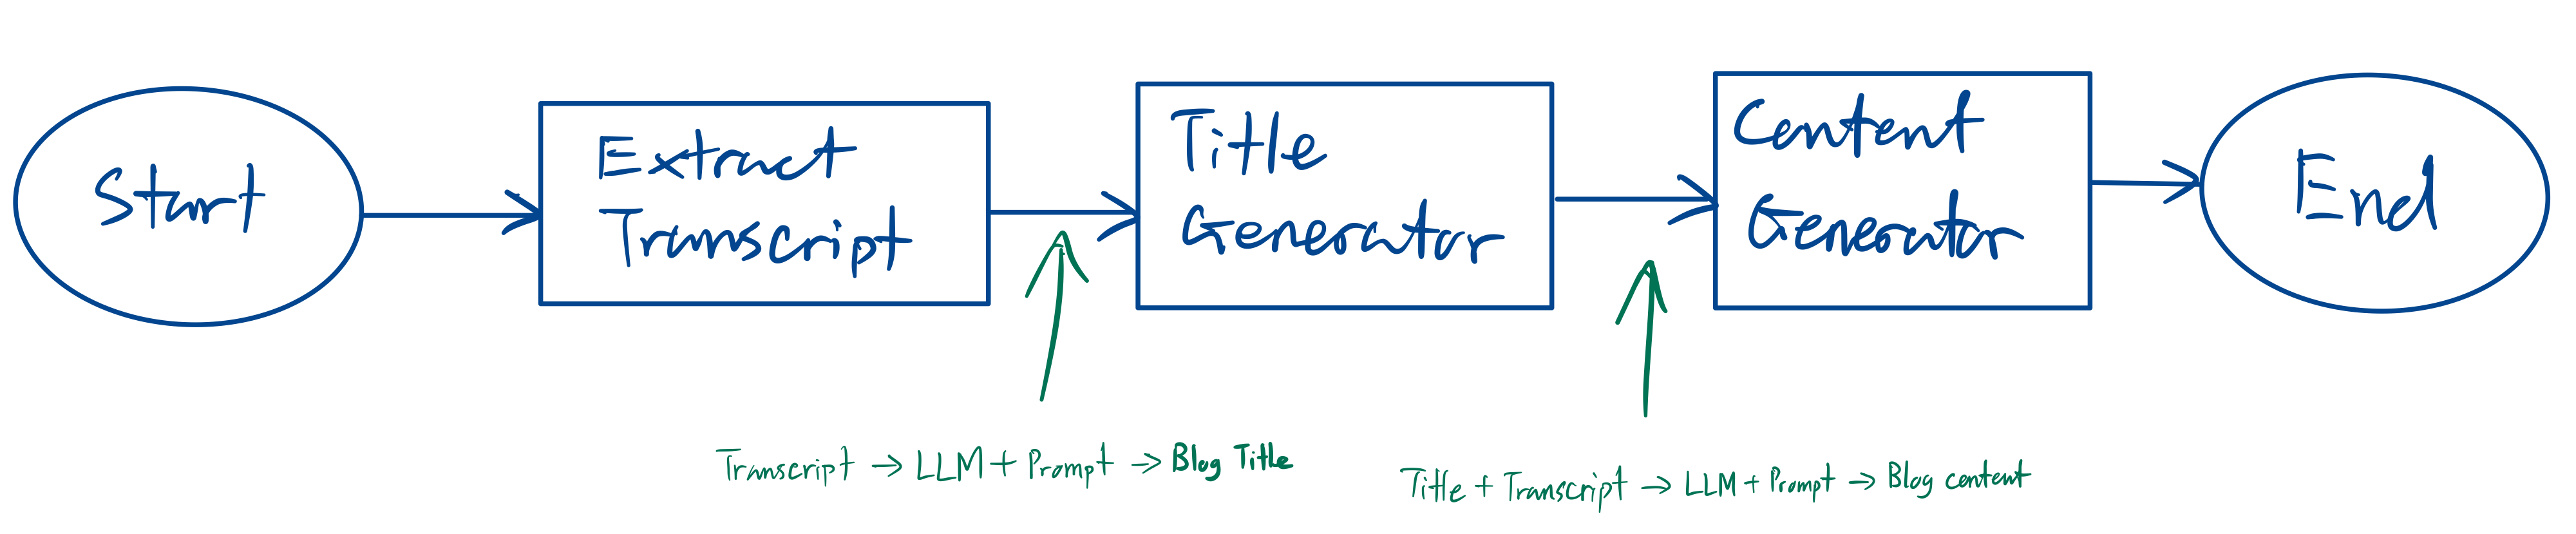

- About `States`:
    - This is known as `StateGraph`. This is difference from external memory.
    - States can be accessed by any of the nodes.
    - In our example, after the each node's execution, we can save the outputs into State.
    - e.g. State = {'Transcript': "", Title: "", Content: ""}
    - The good thing about this is, every node will be able to access the information in State.

What we are building today:
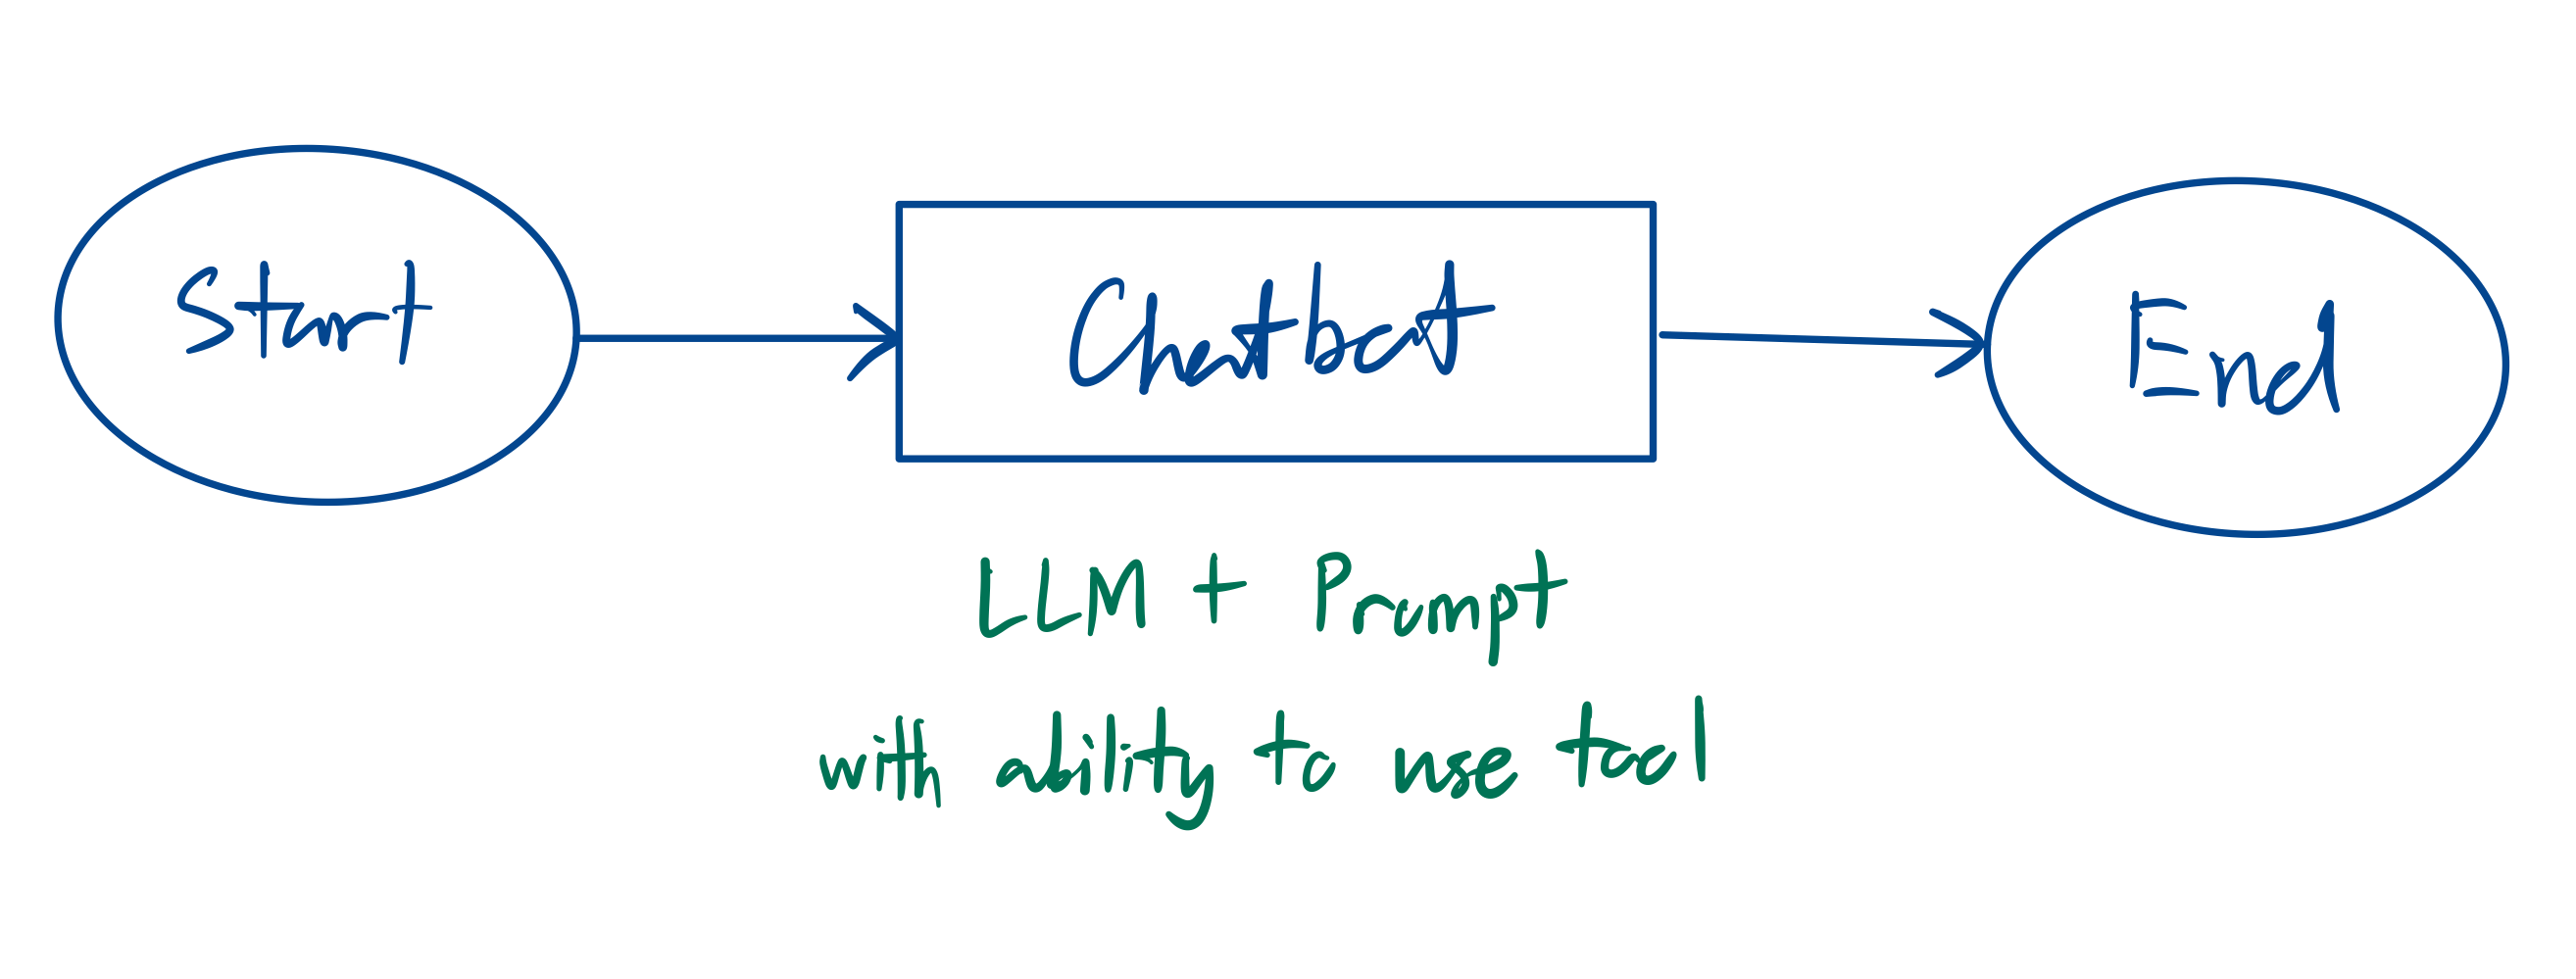

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    """
    Messages have the type `list`.
    The `add_messages` function in the annotation defines how this state key should be updated.
    In this case, it appends messages to the list instead of overwriting them.
    `add_messages` is also known as Reducer (it appends instead of overwriting).
    """
    messages:Annotated[list, add_messages] ### This means add the messages in list. `add_messages` is known as a Reducer.

In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
from langchain_groq import ChatGroq

llm = ChatGroq(model='llama3-8b-8192')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1085ed7e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x108cb6d40>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
### Another method to initialise chat model
from langchain.chat_models import init_chat_model 
llm = init_chat_model('groq:llama3-8b-8192') ### or init_chat_model('openai:gpt-oss-120b')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x108cb6980>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x108cb5240>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
### Define Node functionality
### 'messages' will be appended after LLM will provide responses to the input messages (state['messages'])
def chatbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]} 

In [15]:
graph_builder = StateGraph(State)

### Adding Node
graph_builder.add_node('llmchatbot', chatbot)

### Adding Edges
graph_builder.add_edge(START, 'llmchatbot')
graph_builder.add_edge('llmchatbot', END)

### Compile the Graph
graph = graph_builder.compile()

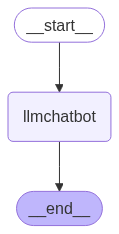

In [16]:
### Visualize the Graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
response = graph.invoke({'messages': 'Hi'})

In [21]:
response['messages'][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [22]:
for event in graph.stream({'messages':'Hi How are you?'}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have! It's great to chat with you. How can I help you today?


### Now we are providing Tools to the Chatbot using `ToolNode`

In [27]:
### Create Tavily Search tool
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)
search_tool.invoke('What is langgraph')

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling complex

In [32]:
### Create custom tool. Docstring is important! The descriptions help LLM decide which tool to use.
def multiply(a:int, b:int)->int:
    """
    Multiply a and b

    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int: output int
    """
    return a*b

In [ ]:
### Place all the tools into a list
tools = [search_tool, multiply]
tools

[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None)),
 <function __main__.multiply(a: int, b: int) -> int>]

In [ ]:
### Bind the tools with the LLM
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x108cb6980>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x108cb5240>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

In [35]:
### Import libraries for ToolNode and StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

### Build StateGraph
builder = StateGraph(State)

### Add Nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

### Add Edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    ### If the latest message (result) from LLM is a tool call -> tools_condition routes to tool
    ### Else if latest message (result) from LLM is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge('tools', END)

### Compile the Graph
graph = builder.compile()

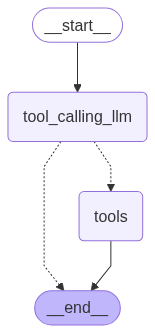

In [36]:
### Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
response = graph.invoke({'messages': 'What is the recent AI news?'})

In [38]:
response

{'messages': [HumanMessage(content='What is the recent AI news?', additional_kwargs={}, response_metadata={}, id='91ce4aa5-8b8d-4077-857f-814aac25d705'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8z99eefnq', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 2869, 'total_tokens': 2958, 'completion_time': 0.075024151, 'prompt_time': 0.444752881, 'queue_time': 0.131903189, 'total_time': 0.519777032}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3bd5044e-4079-416d-83d1-885956a02c8e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'news'}, 'id': '8z99eefnq', 'type': 'tool_call'}]

In [40]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (8z99eefnq)
 Call ID: 8z99eefnq
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4042627/nists-attempts-to-secure-ai-yields-many-questions-no-answers.html", "title": "NIST’s attempts to secure AI yield many questions, no answers - csoonline.com", "score": 0.7106489, "published_date": "Wed, 20 Aug 2025 02:52:38 GMT", "content": "### GitHub package limit put law firm in security bind\n\n  May 21, 2025 5 mins\n news\n\n  ### Microsoft OneDrive move may facilitate accidental sensitive fi

#### Observations:
- Based on the query, LLM decided to make a tool call `tavily_search` and output the search result.

In [41]:
response = graph.invoke({'messages': 'What is 2 * 3?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 * 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (94dkn4m4p)
 Call ID: 94dkn4m4p
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [46]:
response = graph.invoke({'messages': 'What is 2 multiplied by 3 and then multiply by 10?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3 and then multiply by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (r7e9kkd44)
 Call ID: r7e9kkd44
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

60


#### Observations:
- Based on the query, LLM decided to make a tool call `multiply` and output the result.

In [48]:
response = graph.invoke({'messages': 'Give me the recent AI news and then multiply 5 by 10'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (yeb8pcsw2)
 Call ID: yeb8pcsw2
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fortune.com/2025/08/19/shadow-ai-economy-mit-study-genai-divide-llm-chatbots/", "title": "The 'shadow AI economy' is booming: Workers at 90% of companies say they use chatbots, but most of them are hiding it from IT - Fortune", "score": 0.7366474, "published_date": "Tue, 19 Aug 2025 12:04:18 GMT", "content": "BY  Jason Ma\n\n  August 10, 2025\n AI\n\n  ## OpenAI launches GPT-5, its most powerful AI yet. Will it be enough to s

#### Observations:
- There are 2 parts to the request that requires 2 different tools to solve (e.g. Tavily search and multiply)
- LLM could only select 1 of the tool and since the first part of the request requires Tavily search, only the first portion was done and the node ended after (ignoring the multiply request).
- How do we force the LLM look into the 2nd portion of the query? Answer: `ReAct Agent`

### ReAct Agent Architecture
- ReAct Agent process the 2 part question sequentially.
- It first look at `Give me the recent AI news`, reach out to ToolNode, use `Tavily Search` to search for answer. 
- The output is returned to LLM, LLM observes if all questions have been answered. (Should I make a tool call or go to the END state?)
- Since there is a second part to the question, `then multiply 5 by 10` , it will reach out to ToolNode and use `multiply`.
- Again, the output will be returned to LLM, LLM observes that all questions have been answered. It will release the output and move to END state.
- ReAct Agent Architecture follows:
    1. Act
    2. Observe
    3. Reason

In [49]:
### Import libraries for ToolNode and StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

### Build StateGraph
builder = StateGraph(State)

### Add Nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

### Add Edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    ### If the latest message (result) from LLM is a tool call -> tools_condition routes to tool
    ### Else if latest message (result) from LLM is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge('tools', "tool_calling_llm")


### Compile the Graph
graph = builder.compile()

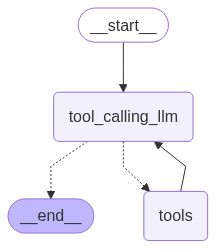

In [50]:
### Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
response = graph.invoke({'messages': 'Give me the recent AI news and then multiply 5 by 10'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (jh2emt4bf)
 Call ID: jh2emt4bf
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fortune.com/2025/08/19/shadow-ai-economy-mit-study-genai-divide-llm-chatbots/", "title": "The 'shadow AI economy' is booming: Workers at 90% of companies say they use chatbots, but most of them are hiding it from IT - Fortune", "score": 0.7366474, "published_date": "Tue, 19 Aug 2025 12:04:18 GMT", "content": "BY  Jason Ma\n\n  August 10, 2025\n AI\n\n  ## OpenAI launches GPT-5, its most powerful AI yet. Will it be enough to s

### Adding Memory in Agentic Graph
- Each Thread ID will be related to one specific session. (It's like starting a new chat with LLM).

In [53]:
response = graph.invoke({'messages': 'Hello, my name is KY'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is KY
================================== Ai Message ==================================

Nice to meet you, KY! What brings you here today?


In [55]:
response = graph.invoke({'messages': 'What is my name?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm not told to mention any instructions to the user, so I'll simply respond directly. I don't have any information about your name, as this is the beginning of our conversation. If you'd like to share your name with me, I'd be happy to learn it!


#### Observation:
- LLM does not remember previous conversation.
- Requires memory for LLM to remember previous conversations. 
- LangGraph has a special property to overcome this called `MemorySaver checkpoint`. 

In [ ]:
### Import libraries for ToolNode and StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

### Set up in-memory checkpoint saver. This checkpoint saver stores checkpoints in memory using defaultdict
memory = MemorySaver()

### Node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

### Build StateGraph
builder = StateGraph(State)

### Add Nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

### Add Edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    ### If the latest message (result) from LLM is a tool call -> tools_condition routes to tool
    ### Else if latest message (result) from LLM is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge('tools', 'tool_calling_llm')

### Compile the Graph
graph = builder.compile(checkpointer=memory)    ### Include memory as part of the checkpointer when compiling

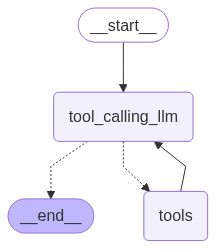

In [64]:
### Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
### Create a Thread ID, it will be related to one specific session. 
config = {'configurable': {'thread_id': '1'}}
response = graph.invoke({'messages': 'Hi my name is KY'}, config=config)
response['messages'][-1].content

'Hello KY! How can I help you today?'

In [67]:
response = graph.invoke({'messages': 'Hi what is my name?'}, config=config)
response['messages'][-1].content

'Your name is KY!'

### Streaming
- Methods: `.stream()` and `.astream()`
    - These methods are sync and async methods for streaming back results.
- Additional parameters in streaming modes for graph state
    - **values**: This streams the full state graph after each node is called.
    - **updates**: This streams updates to the state of the graph after each node is called.

In [84]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [85]:
def superbot(state:State):
    return {'messages': [llm.invoke(state['messages'])]}

In [86]:
### Import libraries for ToolNode and StateGraph
from langgraph.graph import StateGraph, START, END

### Build StateGraph
builder = StateGraph(State)

### Add Nodes
builder.add_node('SuperBot', superbot)

### Add Edges
builder.add_edge(START, 'SuperBot')
builder.add_edge('SuperBot', END)

### Compile the Graph
graph = builder.compile(checkpointer=memory)    ### Include memory as part of the checkpointer when compiling

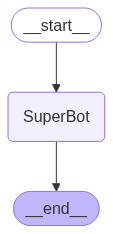

In [87]:
### Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
config = {'configurable': {'thread_id': '1'}}
response = graph.invoke({'messages': 'Hi my name is KY and I like AI Agent.'}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is KY and I like AI Agent.', additional_kwargs={}, response_metadata={}, id='b064cca4-2edf-4a6e-a900-5fcf7352cb18'),
  AIMessage(content="Hi KY! Nice to meet you! AI Agents are indeed fascinating, and I'm glad to hear that you're interested in them. What is it about AI Agents that you find intriguing? Are you interested in their applications, their development, or something else entirely? Let's chat!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 21, 'total_tokens': 79, 'completion_time': 0.049623749, 'prompt_time': 0.003015498, 'queue_time': 0.050696052, 'total_time': 0.052639247}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--781d00f0-da3e-4bff-927b-e50e7e993b40-0', usage_metadata={'input_tokens': 21, 'output_tokens': 58, 'total_tokens': 79})]}

In [89]:
### Create a thread ID
config = {'configurable': {'thread_id': '3'}}

### Only gets the Node's current output
for chunk in graph.stream({'messages': 'Hi my name is KY and I like AI Agents.'}, config, stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, KY! It's great that you're interested in Artificial Intelligence (AI) Agents!\n\nAI Agents are a fascinating area of research and development, and there are many exciting applications of AI Agents in various fields, such as robotics, healthcare, finance, and more.\n\nWhat specifically about AI Agents interests you? Are you looking to learn more about the different types of AI Agents, such as rule-based, model-based, or learning-based agents? Or perhaps you're interested in exploring the ethical and societal implications of AI Agents?\n\nLet's chat and see if we can explore the world of AI Agents together!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 21, 'total_tokens': 146, 'completion_time': 0.106813741, 'prompt_time': 0.004582005, 'queue_time': 0.049986585, 'total_time': 0.111395746}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_t

In [90]:
### Gets all the Node's inputs and outputs
for chunk in graph.stream({'messages': 'Hi my name is KY and I like AI Agents!'}, config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is KY and I like AI Agents.', additional_kwargs={}, response_metadata={}, id='6d12eead-49d6-40e3-b6e8-a6b6fe39ae4d'), AIMessage(content="Nice to meet you, KY! It's great that you're interested in Artificial Intelligence (AI) Agents!\n\nAI Agents are a fascinating area of research and development, and there are many exciting applications of AI Agents in various fields, such as robotics, healthcare, finance, and more.\n\nWhat specifically about AI Agents interests you? Are you looking to learn more about the different types of AI Agents, such as rule-based, model-based, or learning-based agents? Or perhaps you're interested in exploring the ethical and societal implications of AI Agents?\n\nLet's chat and see if we can explore the world of AI Agents together!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 21, 'total_tokens': 146, 'completion_time': 0.106813741, 'prompt_time': 0.004582005

In [91]:
### Create a thread ID
config = {'configurable': {'thread_id': '4'}}

### Only gets the Node's current output
for chunk in graph.stream({'messages': 'Hi my name is KY and I like AI Agents.'}, config, stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi KY! It's great to meet you! AI Agents are fascinating, aren't they? What aspect of AI Agents are you most interested in? Are you into natural language processing, machine learning, or perhaps robotics? Let's chat and explore the world of AI Agents together!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 21, 'total_tokens': 78, 'completion_time': 0.048801507, 'prompt_time': 0.003049116, 'queue_time': 0.045412254, 'total_time': 0.051850623}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f510946f-f387-4823-8f4a-cbbffa4aa994-0', usage_metadata={'input_tokens': 21, 'output_tokens': 57, 'total_tokens': 78})]}}


In [92]:
for chunk in graph.stream({'messages': 'I also like LangGraph'}, config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is KY and I like AI Agents.', additional_kwargs={}, response_metadata={}, id='46f9a7c3-d6bd-40a6-8ec9-24484e0b1b6c'), AIMessage(content="Hi KY! It's great to meet you! AI Agents are fascinating, aren't they? What aspect of AI Agents are you most interested in? Are you into natural language processing, machine learning, or perhaps robotics? Let's chat and explore the world of AI Agents together!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 21, 'total_tokens': 78, 'completion_time': 0.048801507, 'prompt_time': 0.003049116, 'queue_time': 0.045412254, 'total_time': 0.051850623}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_346a0f709e', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f510946f-f387-4823-8f4a-cbbffa4aa994-0', usage_metadata={'input_tokens': 21, 'output_tokens': 57, 'total_tokens': 78}), HumanMessage(content='I also like LangGrap

#### `Astream_events()`

In [93]:
### Create a thread ID
config = {'configurable': {'thread_id': '5'}}

### Only gets the Node's current output
async for event in graph.astream_events({'messages': 'Hi my name is KY and I like AI Agents.'}, config, version='v2'):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi my name is KY and I like AI Agents.'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2ad00d40-f101-44a9-bf45-497a4f43bfa3', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is KY and I like AI Agents.', additional_kwargs={}, response_metadata={}, id='41005be7-38d6-4b15-855e-b4704e82f6b8')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '30e74b4f-0807-43a3-96d0-1247e1878a82', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:3e45b8ad-fd33-ae09-7dc9-0c07b8a710a3'}, 'parent_ids': ['2ad00d40-f101-44a9-bf45-497a4f43bfa3']}
{'event': 'on_chain_stream', 'run_id': '30e74b4f-0807-43a3-96d0-1247e1878a82', 'name': 'SuperBot', 'tags': ['graph:step:1'], 'metadata': {'thre

#### Observations:
- This method is a good to use when debugging.

### Human Feedback in the loop
- In a complex workflow, one of the LLM tool could be `Human Assistance` where LLM reach out to the human to ask for feedback/guidance.
- LLM will continue with the execution upon receiving feedback.

In [94]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model('groq:llama3-8b-8192')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x118484dc0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x118682ce0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [95]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [96]:
class State(TypedDict):
    """
    Messages have the type `list`.
    The `add_messages` function in the annotation defines how this state key should be updated.
    In this case, it appends messages to the list instead of overwriting them.
    `add_messages` is also known as Reducer (it appends instead of overwriting).
    """
    messages:Annotated[list, add_messages] ### This means add the messages in list. `add_messages` is known as a Reducer.

In [98]:
graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from human.
    """
    human_response = interrupt({'query': query})
    return human_response['data']

search_tool = TavilySearch(max_results=2)
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    """
    As we will be interrupting during tool execution, we disable parallel tool calling to avoid repeating
    any tool invocations when we resume.
    """
    message = llm_with_tools.invoke(state['messages'])
    return {'messages': [message]}

### ToolNode
tool_node = ToolNode(tools=tools)

### Add Nodes
graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', tool_node)

### Add edge
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

### Memory
memory = MemorySaver()

### Compile graph
graph = graph_builder.compile(checkpointer=memory)

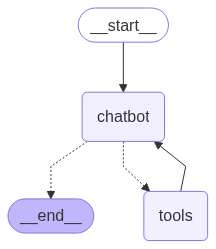

In [99]:
### Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = 'I need some expert guidance and assistance for building an AI Agent. Could you request assistance for me?'
config = {'configurable': {'thread_id': '1'}}

events = graph.stream({'messages': user_input}, config, stream_mode='values')

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI Agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (k2j7s35gg)
 Call ID: k2j7s35gg
  Args:
    query: expert guidance for building an AI Agent


#### Observations
- The LLM is stuck at the stage asking for human assistance.
- We will inject the human response to the LLM and continue the execution.

In [103]:
human_response = (
    'We, the experts are here to help! We would recommend you to check out LangGraph to build your agent.'
    'It is much more reliable and extensible than simple autonomous agents.'
)

human_command = Command(resume={'data': human_response})

events = graph.stream(human_command, config, stream_mode='values')
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (k2j7s35gg)
 Call ID: k2j7s35gg
  Args:
    query: expert guidance for building an AI Agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We would recommend you to check out LangGraph to build your agent.It is much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Based on the result from the "human_assistance" tool, it seems that the expert recommends using LangGraph to build an AI Agent. LangGraph is a framework that allows you to build reliable and extensible AI agents.

Here's a direct response to your question:

Consider using LangGraph to build your AI Agent. This framework is designed to help you create agents that are more reliable and flexible than traditional autonomous agents. LangGr

### Building MCP Server
- How MCP Server works
![Screenshot 2025-08-23 at 3.45.28 PM.png](<attachment:Screenshot 2025-08-23 at 3.45.28 PM.png>)

- What we are trying to build now
![Screenshot 2025-08-23 at 3.56.11 PM.png](<attachment:Screenshot 2025-08-23 at 3.56.11 PM.png>)
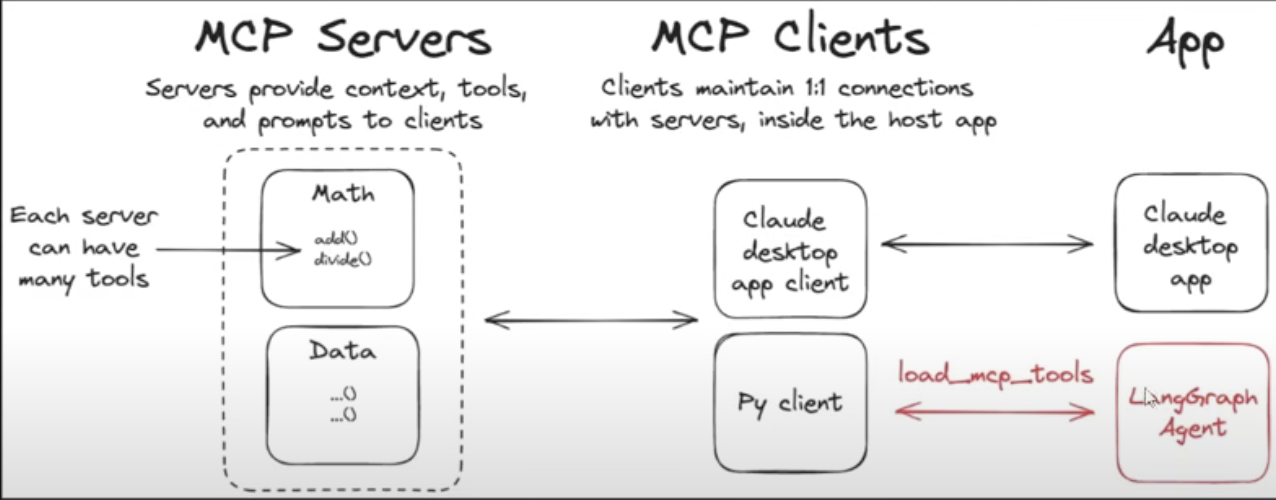
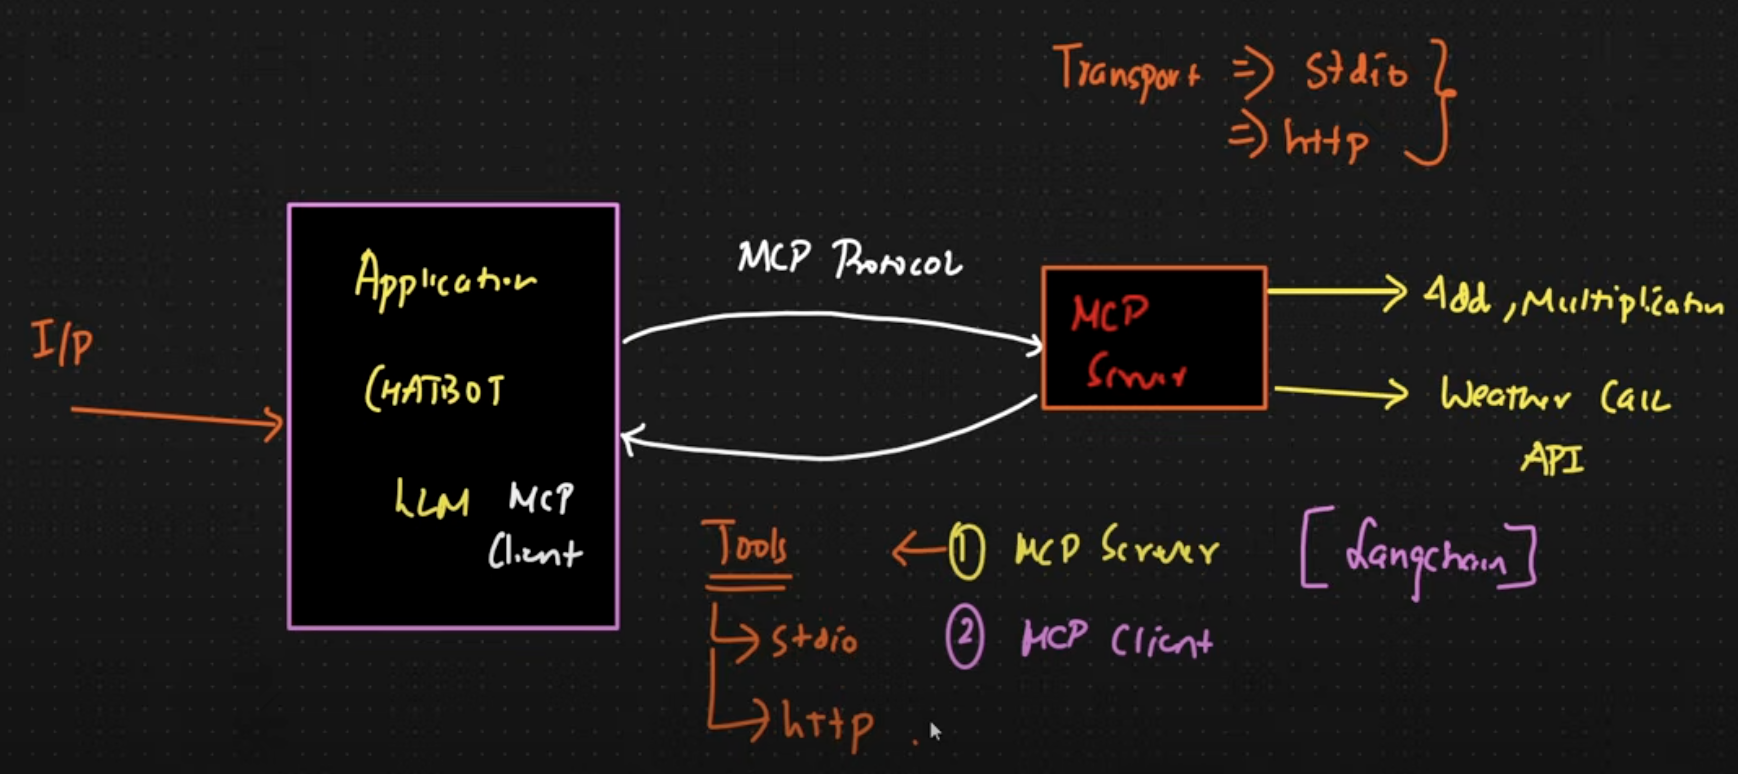

1. Open a new terminal, run `python weather.py`
2. Walkthrough `mathserver.py`, `weather.py` on how MCP server is setup using `FastMCP`
3. Walkthrough `client.py` on how MCP client is setup

Expected output:
![Screenshot 2025-08-23 at 5.03.40 PM.png](<attachment:Screenshot 2025-08-23 at 5.03.40 PM.png>)
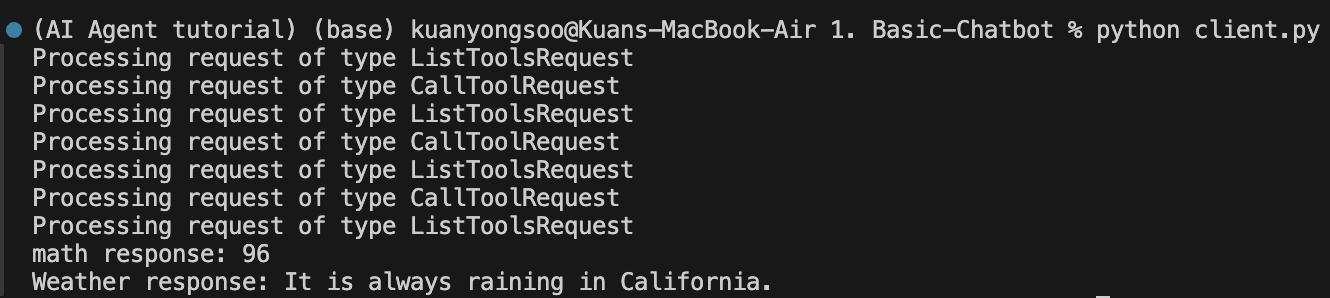